<h1>Setting up the environment and the dataset<h1>

In [2]:
# Importing necessary libraries
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
from keras import Model
from keras import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt
from sklearn.metrics import zero_one_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import tensorflow_addons as tfa

In [3]:
# Setting up the path to locate the dataset
PATH = '/Users/matteocastagna/Documents/Università/Magistrale/1_semestre_2/statistical method for machine learning/progetto/dataset'
data_dir = pathlib.Path(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Number of images in the dataset: {image_count}')

Number of images in the dataset: 5182


In [5]:
# Setting up dimensions of the images that will be fed to the network and number epochs for training (anf hyperparameter
# tuning ) and fine tuning
IMG_HEIGHT = 120
IMG_WIDTH = 120
TUNING_EPOCHS = 10 # number of epochs used for hyperparameters tuning
TOTAL_EPOCHS = 2 * TUNING_EPOCHS # number of epochs used for training
RANDOM_SEED = 100
PATCH_SIZE = 12
NUM_PATCHES = (IMG_HEIGHT // PATCH_SIZE) ** 2 # 100 patches
NUM_HEADS = 1 # One head Transformer is used
PROJECTION_DIM = 200 # Size of the vector in which the image patches are embedded
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Dimension of the output of the Transformer

# Creating the dataset as a tf.data.Dataset. Even if later the training set etc. will be converted to numpy array, loading the dataset
# this way and then converting is still faster than using os to load all the images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode = 'rgb',
  shuffle = False,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = None # The batch size is set to None so it can be tuned later
)

Found 5182 files belonging to 2 classes.


In [6]:
# Printing dataset classes
class_names = ds.class_names
print(f'First class: {class_names[0]}')
print(f'Second class: {class_names[1]}')

First class: chihuahua
Second class: muffin


In [7]:
# Shuffling the dataset
ds = ds.shuffle(buffer_size = ds.cardinality(), reshuffle_each_iteration = False, seed = RANDOM_SEED)

# Splitting the dataset into train and validation set
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size = 0.8, shuffle = False)

# Printing the cardinality of train and validation set
train_card = tf.data.experimental.cardinality(train_ds)
print(f'Training set cardinality: {train_card.numpy()}')
val_card = tf.data.experimental.cardinality(val_ds)
print(f'Validation set cardinality: {val_card.numpy()}')

Training set cardinality: 4146
Validation set cardinality: 1036


In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 120 X 120
Patch size: 12 X 12
Patches per image: 100
Elements per patch: 432


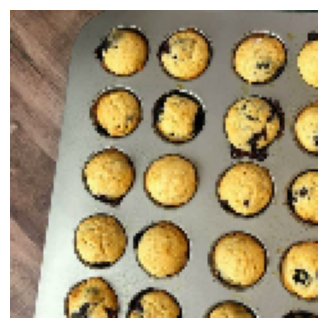

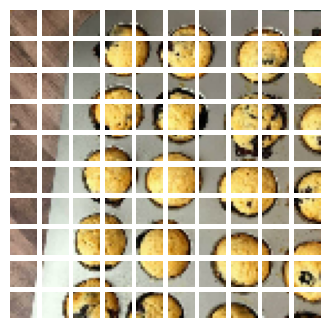

In [9]:
plt.figure(figsize=(4, 4))
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMG_HEIGHT, IMG_WIDTH)
)
patches = Patches(PATCH_SIZE)(resized_image)
print(f"Image size: {IMG_HEIGHT} X {IMG_WIDTH}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

<h1>Setting up the network and performing hyperparameters tuning<h1>

In [10]:
# The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size PROJECTION_DIM.
# In addition, it adds a learnable position embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:

# Keras-tuner HyperModel class let encapsulate a model for sharing and reuse, an hypermodel can be passed to a keras tuner to perform
# keras automatic hyperparameters tuning
class MyHypermodel(kt.HyperModel):
    
    def build(self, hp):
        
        inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        # Create patches.
        patches = Patches(PATCH_SIZE)(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)


        #############################################
        ############# Transformer block #############
        #############################################
        # Normalization layer
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # layers.MultiHeadAttention layer is the self-attention mechanism applied to the sequence of patches
        attention_output = layers.MultiHeadAttention(num_heads = NUM_HEADS, key_dim = PROJECTION_DIM, dropout=0.1)(x1, x1)
        # Prepending the learnable embedding given by the attention mechanism
        # to the sequence of encoded patches to serve as the image representation
        x2 = layers.Add()([attention_output, encoded_patches])
        # Normalization
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Transformers MLP
        for units in TRANSFORMER_UNITS:
                # Gaussian Error Linear Unit is used as activation function, a full differentiable version of ReLU
                x3 = layers.Dense(units, activation = tf.nn.gelu)(x3)
                x3 = layers.Dropout(0.1)(x3)
        encoded_patches = layers.Add()([x3, x2])

        ###############################################
        ############# Classification head #############
        ###############################################
        x = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        x = layers.Flatten()(x)
        x = layers.Dense(16)(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(1)(x)
        x = layers.Activation('sigmoid')(x)
        
        # Create the Keras model.
        model = Model(inputs, x)
        
        model.compile(
            optimizer = tfa.optimizers.AdamW(learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3]),
                weight_decay = hp.Choice('weigth_decay', values = [1e-1, 1e-2, 1e-3])),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'],
        )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tuning the batch size, choosing an optimal value from 16, 32 or 48
            batch_size = hp.Choice("batch_size", values = [32, 64, 128, 256]),
            **kwargs,
        )

# As when loading the dataset previously the batch size was setted to None, the dataset is made of single examples (height x width x channel),
# but functions such as tuner.search(*), fit(*), etc. expect as input something like (batch_size x height x width x channel);
# therefore I convert training and validation set from tensorflow dataset to numpy array and split samples from labels,
# then feed the model with them instead of the tensorflow dataset
X_train = np.asarray(list(train_ds.map(lambda x, y: x)))
Y_train = np.asarray(list(train_ds.map(lambda x, y: y)))
X_val= np.asarray(list(val_ds.map(lambda x, y: x)))
Y_val = np.asarray(list(val_ds.map(lambda x, y: y)))

del train_ds, val_ds

# The keras GridSearch tuner just iterates over all the hyperparameters combinations, in this case we would get 9 trials total
tuner = kt.GridSearch(
    MyHypermodel(),
    objective = 'val_accuracy',
    directory = 'vit/best_hyperparameters',
    project_name = 'tuning',
    overwrite = True,
    seed = RANDOM_SEED
)

# Early stopping for the hyperparameter tuning
stop_early = EarlyStopping(monitor='val_loss', patience = 5, verbose = 1)

tuner.search(X_train, Y_train,
             epochs = TUNING_EPOCHS,
             callbacks = [stop_early],
             validation_data = (X_val, Y_val),
             shuffle = False,
)

# Printing best hyperparameters
print("", end="\n")
print(f'Best learning rate: {tuner.get_best_hyperparameters()[0]["learning_rate"]}')
print(f'Best batch size: {tuner.get_best_hyperparameters()[0]["weigth_decay"]}')
print(f'Best batch size: {tuner.get_best_hyperparameters()[0]["batch_size"]}')

Trial 36 Complete [00h 01m 17s]
val_accuracy: 0.7181467413902283

Best val_accuracy So Far: 0.7548262476921082
Total elapsed time: 00h 46m 18s
INFO:tensorflow:Oracle triggered exit

Best learning rate: 0.001
Best batch size: 0.001
Best batch size: 32


In [13]:
# Plotting the performances of the models generated by the various combinations of hyperparameters
# Plotting both the parallel plot and the dataframe with the hyperparameters and validation accuracy score for a more
# comprehensive visualization
import plotly.express as px
import pandas as pd

l_trial = []
l_lr = []
l_bs = []
l_wd = []
l_score = []
for trial in tuner.oracle.trials.values():
    l_trial.append(int(trial.trial_id) + 1)
    l_lr.append(trial.hyperparameters["learning_rate"])
    l_wd.append(trial.hyperparameters["weigth_decay"])
    l_bs.append(trial.hyperparameters["batch_size"])
    l_score.append(trial.score)
    
df = pd.DataFrame(list(zip(l_trial, l_lr, l_wd, l_bs, l_score)),
               columns =['Trial #', 'Learning rate', 'Weigth Decay', 'Batch size', 'Validation accuracy'])

# parallel_categories instead of parallel_coordinates helps visualize better the results of the tuning in terms of tracing the
# hyperparameters of each trial. The lighter (yellow) is the color the better the score of the corresponding trial is, the
# darker (blue) is the color the worst the score of the corresponding trial is
fig = px.parallel_categories(df, color="Validation accuracy", labels={'Trial #': 'Trial #', 'Learning rate' : 'Learning rate',
                                                                      'Weigth Decay' : 'Weigth Decay', 'Batch size' : 'Batch size',
                                                                      'Validation accuracy' :  'Validation accuracy'})

fig.update(layout_coloraxis_showscale=False)
fig.show()

df

Trial #  Learning rate  Weigth Decay  Batch size  Validation accuracy
0         1          0.100         0.100          32             0.509652
1         2          0.100         0.100          64             0.509652
2         3          0.100         0.100         128             0.509652
3         4          0.100         0.100         256             0.509652
4         5          0.100         0.010          32             0.516409
5         6          0.100         0.010          64             0.529923
6         7          0.100         0.010         128             0.554054
7         8          0.100         0.010         256             0.513514
8         9          0.100         0.001          32             0.729730
9        10          0.100         0.001          64             0.723938
10       11          0.100         0.001         128             0.537645
11       12          0.100         0.001         256             0.634170
12       13          0.010         0.100          32             0.509652
13       14          0.010         0.100          64             0.509652
14       15          0.010         0.100         128             0.509652
15       16          0.010         0.100         256             0.509652
16       17          0.010         0.010          32             0.513514
17       18          0.010         0.010          64             0.536680
18       19          0.010         0.010         128             0.715251
19       20          0.010         0.010         256             0.580116
20       21          0.010         0.001          32             0.722973
21       22          0.010         0.001          64             0.718147
22       23          0.010         0.001         128             0.725869
23       24          0.010         0.001         256             0.719112
24       25          0.001         0.100          32             0.509652
25       26          0.001         0.100          64             0.509652
26       27          0.001         0.100         128             0.509652
27       28          0.001         0.100         256             0.509652
28       29          0.001         0.010          32             0.722008
29       30          0.001         0.010          64             0.729730
30       31          0.001         0.010         128             0.727799
31       32          0.001         0.010         256             0.737452
32       33          0.001         0.001          32             0.754826
33       34          0.001         0.001          64             0.737452
34       35          0.001         0.001         128             0.738417
35       36          0.001         0.001         256             0.718147

<h1>5-Fold Cross Validation<h1>

In [14]:
# Setting up 5-fold cross validation
kfold = KFold(n_splits = 5, shuffle = False)

# Splitting samples from labels of the dataset
X = np.asarray(list(ds.map(lambda x, y: x)))
Y = np.asarray(list(ds.map(lambda x, y: y)))

del X_train, Y_train, X_val, Y_val

In [15]:
i = 0
model_history_train = [] # List to save train losses and accuracies of the models over each epoch
model_history_val = [] # List to save validation losses and accuracies of the models over each epoch
# Y_pred_list and Y_val_list are used later to plot the confusion matrix of the 5-fold cross validation models
Y_pred_list = [] # List to save each model prediction during validation
Y_val_list = [] # List to save validation set labels of each model
n_chihuahua_muffin = [] # List to save the number of chiahuahua and muffin examples per partition to look later if they were balanced

for train_index, test_index in kfold.split(X):
    
    ##############################################
    ################## Training ##################
    ##############################################
    
    print(f'Fold {i + 1}')
    
    X_train, X_val = X[train_index], X[test_index] # Building the training set
    Y_train, Y_val = Y[train_index], Y[test_index] # Building the validation set
    
    # Creating (substituting to an already existing one) the directory that will contain the checkpoints
    checkpoint_path = f"vit/bst_mdl_{i + 1}/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    # Retrieving the model with the best hyperparameters
    model = tuner.get_best_models()[0]
    
    # Preparing keras callback to save the best model. The new weights of the model will be saved each time
    # its accuracy is better then the previous one.
    # Weights cannot be saved in the much more handy h5 format as the network has not all the parameters trainable,
    # therefore when loading the h5 file for fine tuning, where new layers of network will be trainable, the number
    # of parameters saved previously and the new number of trainable parameters missmatch and cause an error.
    model_checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only = True,
                                                save_best_only = True, monitor = 'accuracy', mode = 'max', verbose = 1)
    
    # Early stopping callback
    model_earlystopping_callback = EarlyStopping(monitor = 'loss', patience = 10, verbose = 1)

    fitted = model.fit(
        X_train, Y_train,
        epochs = TOTAL_EPOCHS,
        callbacks = [model_checkpoint_callback, model_earlystopping_callback],
        shuffle = False,
        batch_size = tuner.get_best_hyperparameters()[0]["batch_size"],
        verbose = 2
    )
    
    # Saving accuracy and loss copmuted over each epoch, during training for the current model
    acc = fitted.history['accuracy']
    loss = fitted.history['loss']
    
    # Saving training losses and accuracies of each mdoel
    trained = {'loss': loss, 'accuracy': acc}
    model_history_train.append(trained)
    
    ##############################################
    ################# Validation #################
    ##############################################
    
    model.load_weights(checkpoint_path)
    
    Y_hat = model.predict(
        X_val,
        batch_size = 1,
        verbose = 2,
    )
    
    # saving predictions and original labels to plot confusion matrix later
    Y_pred = np.rint(Y_hat)
    Y_pred_list.append(Y_pred)
    Y_val_list.append(Y_val)
    
    # Saving validation losses and accuracies of each model
    predicted = {'loss': [], 'accuracy': []}
    predicted['loss'].append(zero_one_loss(Y_val, Y_pred))
    predicted['accuracy'].append(accuracy_score(Y_val, Y_pred))
    model_history_val.append(predicted)
    
    # Saving the number of chiahuahua and muffin examples per partition to look later if they were balanced
    n_muffin_train = np.count_nonzero(Y_train)
    n_chihuahua_train = Y_train.size - n_muffin_train
    n_muffin_val = np.count_nonzero(Y_val)
    n_chihuahua_val = Y_val.size - n_muffin_val
    n_dict = {'train_chihuahua': n_chihuahua_train, 'train_muffin': n_muffin_train,
            'val_chihuahua': n_chihuahua_val, 'val_muffin': n_muffin_val}
    n_chihuahua_muffin.append(n_dict)
    
    print("", end="\n\n\n")
    
    i += 1
    

Fold 1
Epoch 1/20


2023-09-11 16:52:20.327300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.82992, saving model to vit/bst_mdl_1/cp.ckpt
130/130 - 26s - loss: 0.3874 - accuracy: 0.8299 - 26s/epoch - 199ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.82992 to 0.86610, saving model to vit/bst_mdl_1/cp.ckpt
130/130 - 10s - loss: 0.3448 - accuracy: 0.8661 - 10s/epoch - 76ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.86610 to 0.89264, saving model to vit/bst_mdl_1/cp.ckpt
130/130 - 9s - loss: 0.3036 - accuracy: 0.8926 - 9s/epoch - 71ms/step
Epoch 4/20

Epoch 4: accuracy did not improve from 0.89264
130/130 - 10s - loss: 0.2921 - accuracy: 0.8905 - 10s/epoch - 76ms/step
Epoch 5/20

Epoch 5: accuracy improved from 0.89264 to 0.89867, saving model to vit/bst_mdl_1/cp.ckpt
130/130 - 9s - loss: 0.2738 - accuracy: 0.8987 - 9s/epoch - 72ms/step
Epoch 6/20

Epoch 6: accuracy improved from 0.89867 to 0.91749, saving model to vit/bst_mdl_1/cp.ckpt
130/130 - 10s - loss: 0.2477 - accuracy: 0.9175 - 10s/epoch - 75ms/step
Epoch 7/20

Epoc

2023-09-11 16:55:42.173457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1037/1037 - 12s - 12s/epoch - 12ms/step



Fold 2
Epoch 1/20


2023-09-11 16:55:57.395023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.83788, saving model to vit/bst_mdl_2/cp.ckpt
130/130 - 24s - loss: 0.3750 - accuracy: 0.8379 - 24s/epoch - 187ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.83788 to 0.87527, saving model to vit/bst_mdl_2/cp.ckpt
130/130 - 10s - loss: 0.3325 - accuracy: 0.8753 - 10s/epoch - 77ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.87527 to 0.90326, saving model to vit/bst_mdl_2/cp.ckpt
130/130 - 10s - loss: 0.2946 - accuracy: 0.9033 - 10s/epoch - 78ms/step
Epoch 4/20

Epoch 4: accuracy improved from 0.90326 to 0.90470, saving model to vit/bst_mdl_2/cp.ckpt
130/130 - 10s - loss: 0.2765 - accuracy: 0.9047 - 10s/epoch - 78ms/step
Epoch 5/20

Epoch 5: accuracy improved from 0.90470 to 0.91580, saving model to vit/bst_mdl_2/cp.ckpt
130/130 - 10s - loss: 0.2504 - accuracy: 0.9158 - 10s/epoch - 77ms/step
Epoch 6/20

Epoch 6: accuracy improved from 0.91580 to 0.92786, saving model to vit/bst_mdl_2/cp.ckpt
130/130 - 10s - loss: 0.2260 - accuracy: 

2023-09-11 16:59:24.237381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1037/1037 - 12s - 12s/epoch - 12ms/step



Fold 3
Epoch 1/20


2023-09-11 16:59:39.235527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.85142, saving model to vit/bst_mdl_3/cp.ckpt
130/130 - 24s - loss: 0.3601 - accuracy: 0.8514 - 24s/epoch - 188ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.85142 to 0.87603, saving model to vit/bst_mdl_3/cp.ckpt
130/130 - 10s - loss: 0.3263 - accuracy: 0.8760 - 10s/epoch - 74ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.87603 to 0.89267, saving model to vit/bst_mdl_3/cp.ckpt
130/130 - 9s - loss: 0.2985 - accuracy: 0.8927 - 9s/epoch - 73ms/step
Epoch 4/20

Epoch 4: accuracy improved from 0.89267 to 0.91196, saving model to vit/bst_mdl_3/cp.ckpt
130/130 - 9s - loss: 0.2689 - accuracy: 0.9120 - 9s/epoch - 72ms/step
Epoch 5/20

Epoch 5: accuracy improved from 0.91196 to 0.91462, saving model to vit/bst_mdl_3/cp.ckpt
130/130 - 9s - loss: 0.2557 - accuracy: 0.9146 - 9s/epoch - 73ms/step
Epoch 6/20

Epoch 6: accuracy did not improve from 0.91462
130/130 - 9s - loss: 0.2773 - accuracy: 0.8944 - 9s/epoch - 69ms/step
Epoch 7/20

Epoch 7:

2023-09-11 17:02:59.378870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 11s - 11s/epoch - 11ms/step



Fold 4
Epoch 1/20


2023-09-11 17:03:13.505794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.85890, saving model to vit/bst_mdl_4/cp.ckpt
130/130 - 24s - loss: 0.3495 - accuracy: 0.8589 - 24s/epoch - 184ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.85890 to 0.88085, saving model to vit/bst_mdl_4/cp.ckpt
130/130 - 9s - loss: 0.3256 - accuracy: 0.8808 - 9s/epoch - 69ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.88085 to 0.89773, saving model to vit/bst_mdl_4/cp.ckpt
130/130 - 9s - loss: 0.2890 - accuracy: 0.8977 - 9s/epoch - 68ms/step
Epoch 4/20

Epoch 4: accuracy improved from 0.89773 to 0.91606, saving model to vit/bst_mdl_4/cp.ckpt
130/130 - 9s - loss: 0.2600 - accuracy: 0.9161 - 9s/epoch - 68ms/step
Epoch 5/20

Epoch 5: accuracy improved from 0.91606 to 0.92740, saving model to vit/bst_mdl_4/cp.ckpt
130/130 - 9s - loss: 0.2364 - accuracy: 0.9274 - 9s/epoch - 68ms/step
Epoch 6/20

Epoch 6: accuracy improved from 0.92740 to 0.92861, saving model to vit/bst_mdl_4/cp.ckpt
130/130 - 8s - loss: 0.2247 - accuracy: 0.9286 - 

2023-09-11 17:06:23.648127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 11s - 11s/epoch - 11ms/step



Fold 5
Epoch 1/20


2023-09-11 17:06:38.035894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.91944, saving model to vit/bst_mdl_5/cp.ckpt
130/130 - 26s - loss: 0.2502 - accuracy: 0.9194 - 26s/epoch - 198ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.91944 to 0.94428, saving model to vit/bst_mdl_5/cp.ckpt
130/130 - 11s - loss: 0.2164 - accuracy: 0.9443 - 11s/epoch - 82ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.94428 to 0.94718, saving model to vit/bst_mdl_5/cp.ckpt
130/130 - 9s - loss: 0.2004 - accuracy: 0.9472 - 9s/epoch - 69ms/step
Epoch 4/20

Epoch 4: accuracy did not improve from 0.94718
130/130 - 9s - loss: 0.2061 - accuracy: 0.9409 - 9s/epoch - 68ms/step
Epoch 5/20

Epoch 5: accuracy did not improve from 0.94718
130/130 - 9s - loss: 0.2430 - accuracy: 0.9057 - 9s/epoch - 67ms/step
Epoch 6/20

Epoch 6: accuracy did not improve from 0.94718
130/130 - 8s - loss: 0.2246 - accuracy: 0.9209 - 8s/epoch - 64ms/step
Epoch 7/20

Epoch 7: accuracy did not improve from 0.94718
130/130 - 9s - loss: 0.2336 - accuracy: 0.9139 

2023-09-11 17:09:59.293289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 13s - 13s/epoch - 12ms/step





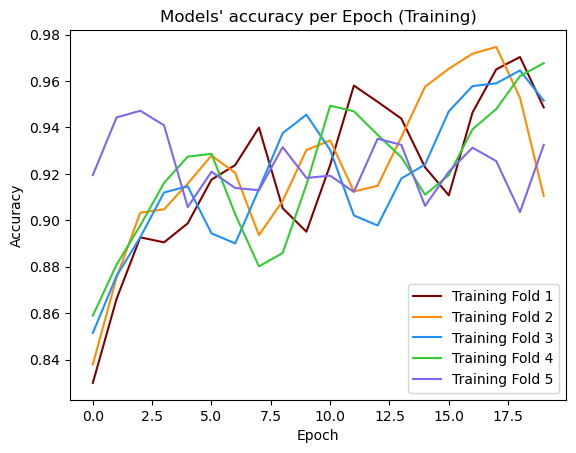

In [16]:
plt.title('Models\' accuracy per Epoch (Training)')
plt.plot(model_history_train[0]['accuracy'], label='Training Fold 1', color = 'maroon', linestyle = 'solid')
plt.plot(model_history_train[1]['accuracy'], label='Training Fold 2', color = 'darkorange', linestyle = 'solid')
plt.plot(model_history_train[2]['accuracy'], label='Training Fold 3', color = 'dodgerblue', linestyle = 'solid')
plt.plot(model_history_train[3]['accuracy'], label='Training Fold 4', color = 'limegreen', linestyle = 'solid')
plt.plot(model_history_train[4]['accuracy'], label='Training Fold 5', color = 'mediumslateblue', linestyle = 'solid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

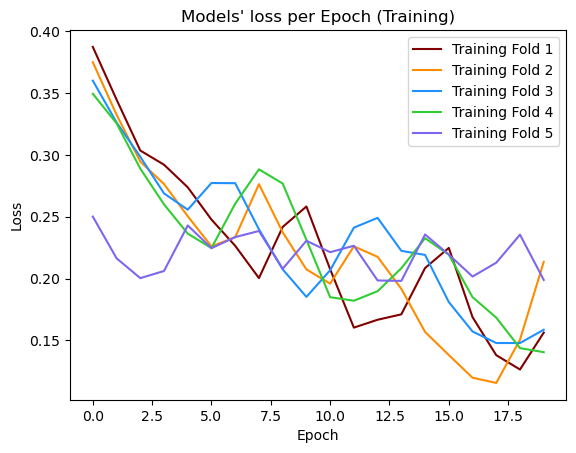

In [17]:
plt.title('Models\' loss per Epoch (Training)')
plt.plot(model_history_train[0]['loss'], label='Training Fold 1', color = 'maroon', linestyle = 'solid')
plt.plot(model_history_train[1]['loss'], label='Training Fold 2', color = 'darkorange', linestyle = 'solid')
plt.plot(model_history_train[2]['loss'], label='Training Fold 3', color = 'dodgerblue', linestyle = 'solid')
plt.plot(model_history_train[3]['loss'], label='Training Fold 4', color = 'limegreen', linestyle = 'solid')
plt.plot(model_history_train[4]['loss'], label='Training Fold 5', color = 'mediumslateblue', linestyle = 'solid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---------- Model 1 ---------
Recall score: 0.6023856858846919
Precision score: 0.7632241813602015
F1-score : 0.6733333333333333

---------- Model 2 ---------
Recall score: 0.7064393939393939
Precision score: 0.7270955165692008
F1-score : 0.7166186359269934

---------- Model 3 ---------
Recall score: 0.7242718446601941
Precision score: 0.7535353535353535
F1-score : 0.7386138613861386

---------- Model 4 ---------
Recall score: 0.725897920604915
Precision score: 0.7804878048780488
F1-score : 0.752203721841332

---------- Model 5 ---------
Recall score: 0.38446969696969696
Precision score: 0.875
F1-score : 0.5342105263157895



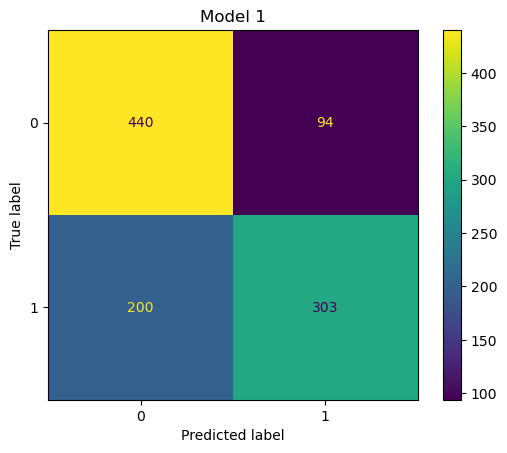

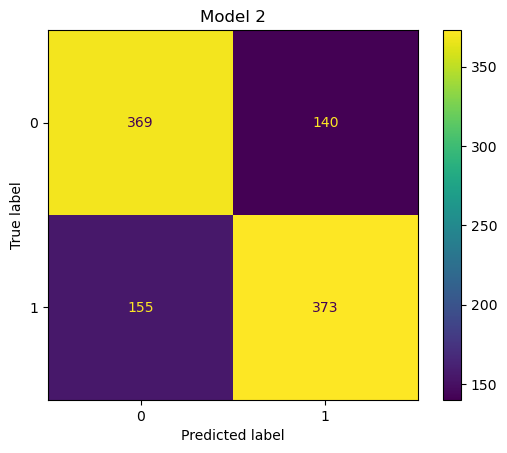

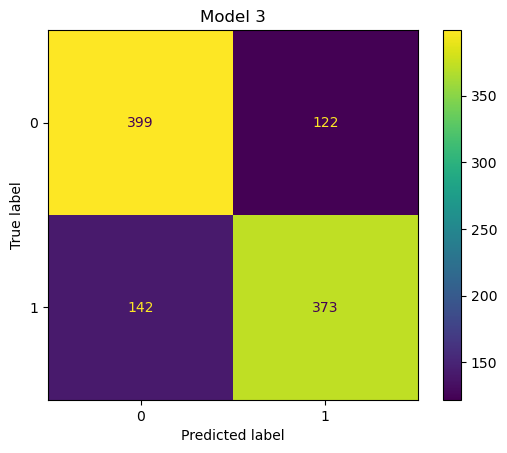

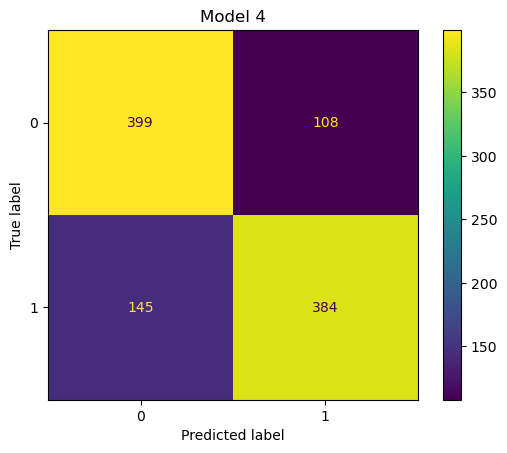

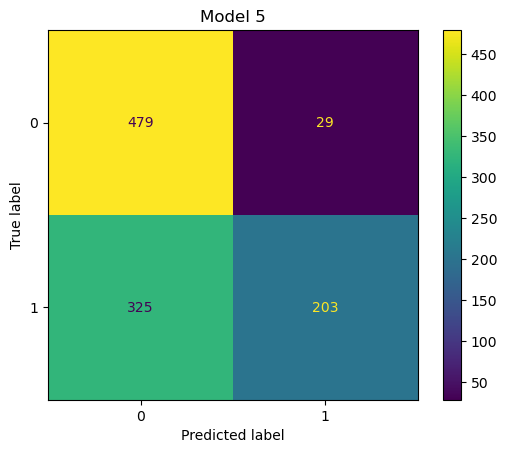

In [18]:
# Printing confusion matrices for the validation folds
i = 0
for pred in Y_pred_list:
    print(f"---------- Model {i + 1} ---------")
    print(f'Recall score: {recall_score(Y_val_list[i], pred)}')
    print(f'Precision score: {precision_score(Y_val_list[i], pred)}')
    print(f'F1-score : {f1_score(Y_val_list[i], pred)}')
    print("", end="\n")
    cm = confusion_matrix(Y_val_list[i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    plt.title(f"Model {i+1}")
    i += 1

In [19]:
# Printing zero-one loss and accuracy on the validations folds
i = 1
for stats in model_history_val:
    print(f"---------- Model {i} ---------")
    print(f"Zero-one loss: {stats['loss'][0]}")
    print(f"Accuracy: {stats['accuracy'][0]}")
    print("", end="\n\n")
    i += 1

---------- Model 1 ---------
Zero-one loss: 0.28351012536162
Accuracy: 0.71648987463838


---------- Model 2 ---------
Zero-one loss: 0.2844744455159113
Accuracy: 0.7155255544840887


---------- Model 3 ---------
Zero-one loss: 0.25482625482625487
Accuracy: 0.7451737451737451


---------- Model 4 ---------
Zero-one loss: 0.24420849420849422
Accuracy: 0.7557915057915058


---------- Model 5 ---------
Zero-one loss: 0.3416988416988417
Accuracy: 0.6583011583011583




<h1>Explainability<h1>

In [20]:
i = 1
for n_per_model in n_chihuahua_muffin:
    print(f'Fold {i}')
    print(f'Percentage of chihuahua examples (train) {i + 1}: { round( ( n_per_model["train_chihuahua"] / ( n_per_model["train_chihuahua"] + n_per_model["train_muffin"] ) ) * 100 ) }')
    print(f'Percentage of muffin examples (train) {i + 1}: { round( ( n_per_model["train_muffin"] / ( n_per_model["train_chihuahua"] + n_per_model["train_muffin"] ) ) * 100 ) }')
    print(f'Percentage of chihuahua examples (validation) {i + 1}: { round( ( n_per_model["val_chihuahua"] / ( n_per_model["val_chihuahua"] + n_per_model["val_muffin"] ) ) * 100 ) }')
    print(f'Percentage of muffin examples (validation) {i + 1}: { round( ( n_per_model["val_muffin"] / ( n_per_model["val_chihuahua"] + n_per_model["val_muffin"] ) ) * 100 ) }')
    print("", end="\n")
    i += 1

Fold 1
Percentage of chihuahua examples (train) 2: 49
Percentage of muffin examples (train) 2: 51
Percentage of chihuahua examples (validation) 2: 51
Percentage of muffin examples (validation) 2: 49

Fold 2
Percentage of chihuahua examples (train) 3: 50
Percentage of muffin examples (train) 3: 50
Percentage of chihuahua examples (validation) 3: 49
Percentage of muffin examples (validation) 3: 51

Fold 3
Percentage of chihuahua examples (train) 4: 50
Percentage of muffin examples (train) 4: 50
Percentage of chihuahua examples (validation) 4: 50
Percentage of muffin examples (validation) 4: 50

Fold 4
Percentage of chihuahua examples (train) 5: 50
Percentage of muffin examples (train) 5: 50
Percentage of chihuahua examples (validation) 5: 49
Percentage of muffin examples (validation) 5: 51

Fold 5
Percentage of chihuahua examples (train) 6: 50
Percentage of muffin examples (train) 6: 50
Percentage of chihuahua examples (validation) 6: 49
Percentage of muffin examples (validation) 6: 51



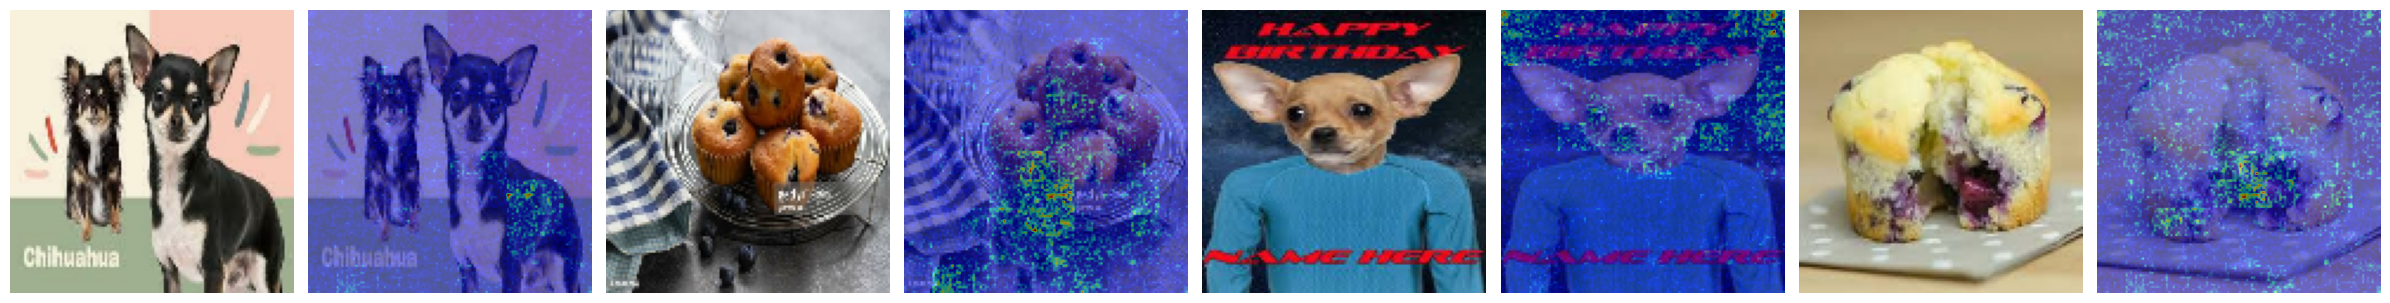

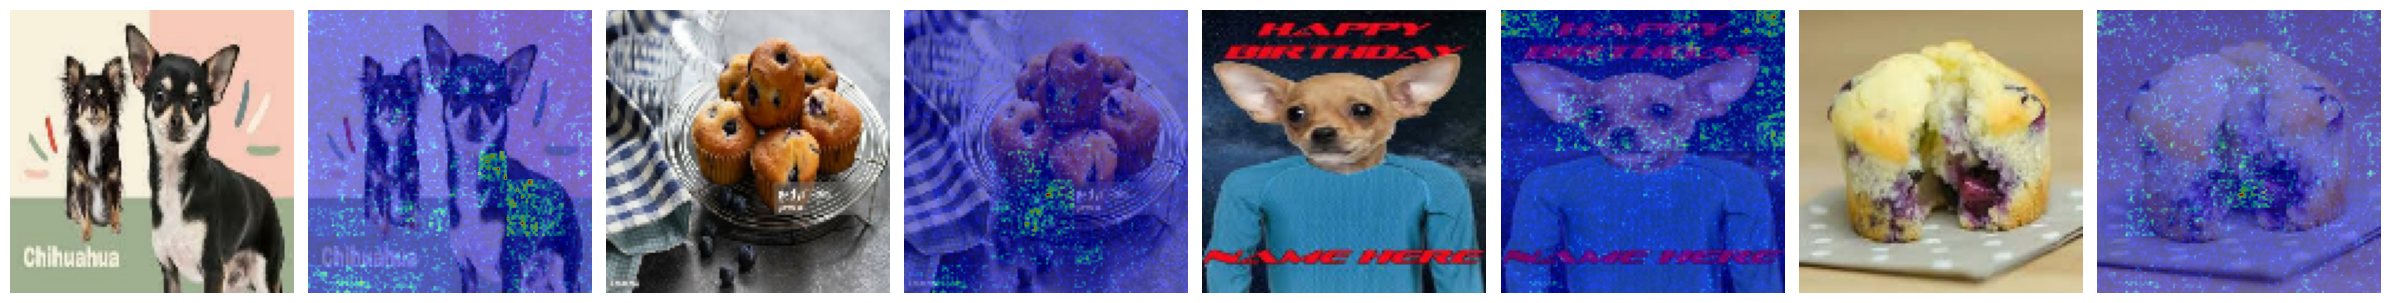

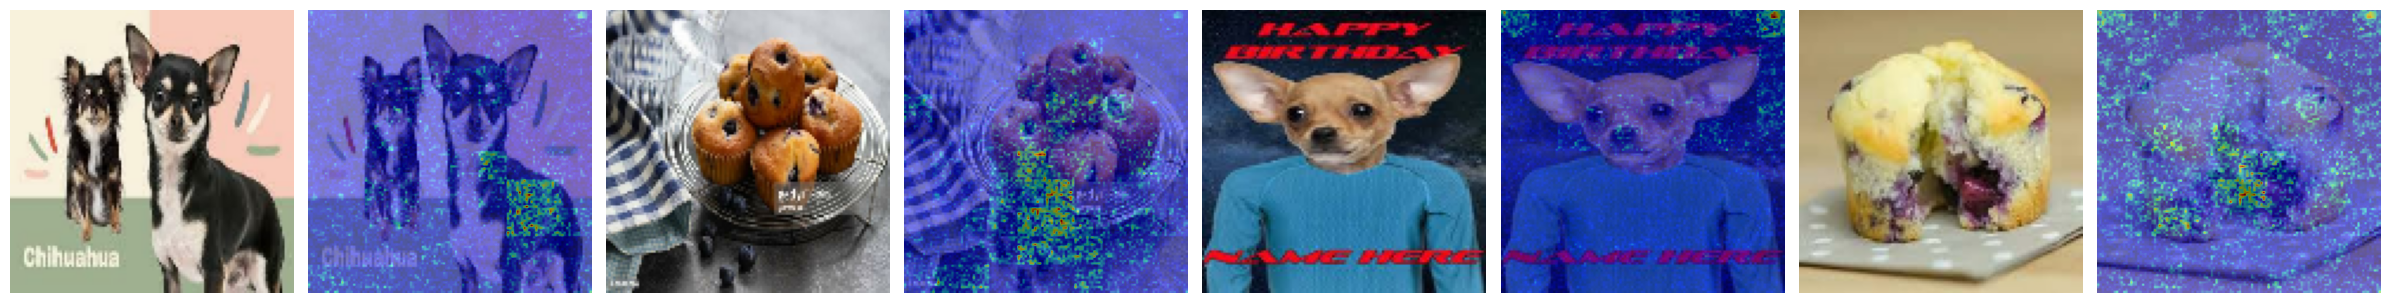

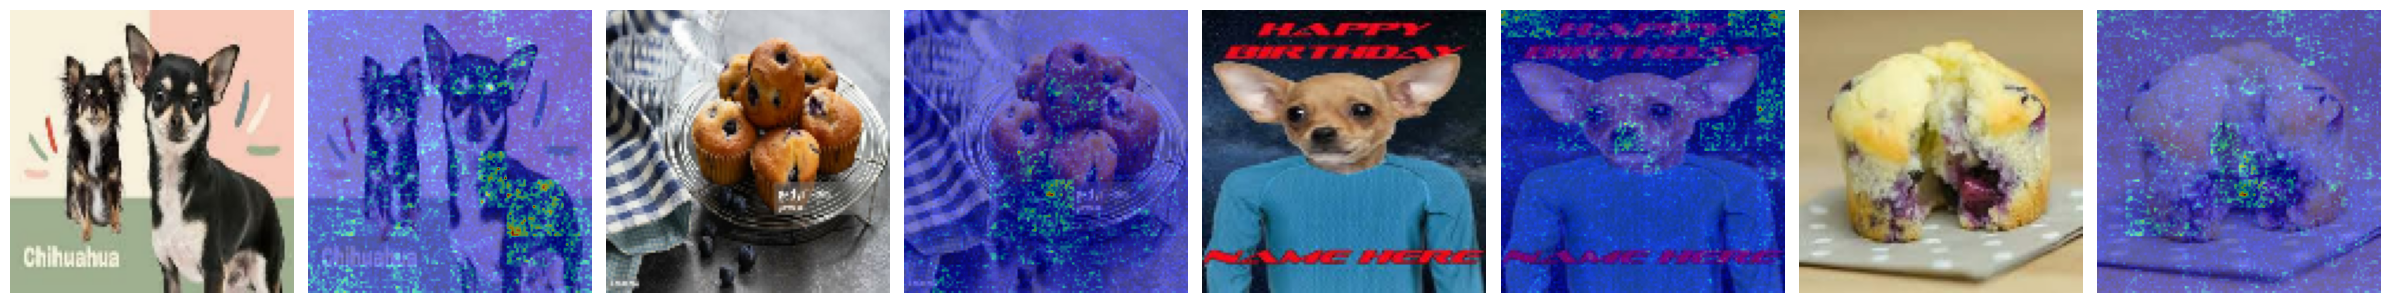

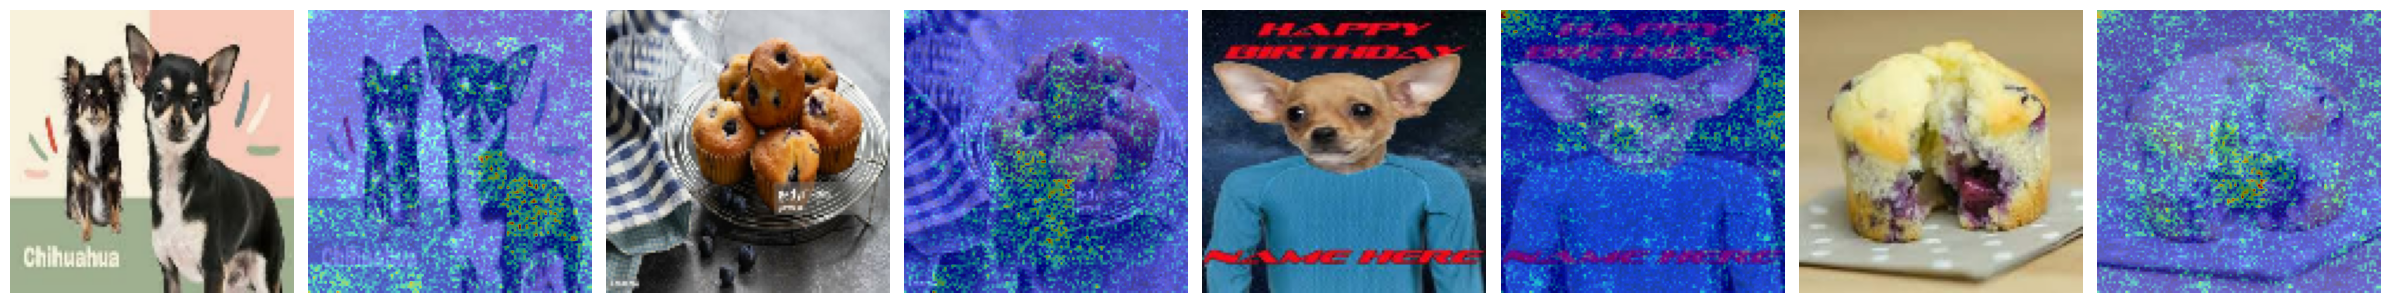

In [22]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.saliency import Saliency

# In the for loop, each one of the 5-cross validation model is retrieved. As they're only used for prediction by the function 'Saliency' and
# they're not used for training, there are some unused values, in particular the one about the optimizer (learning rate, beta_1, beta_2). Those
# cause tensorflow to raise unnecessary warnings in this context, therefore tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# is use to turn off tensorflow log messages to avoid the unnecessary warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

replace2linear = ReplaceToLinear()

i = 0
for i in range(5):
    
    model = tuner.get_best_models()[0]
    model.load_weights(f"vit/bst_mdl_{i + 1}/cp.ckpt")

    saliency = Saliency(model,
                        model_modifier = replace2linear,
                        clone = True)

    score = BinaryScore([Y[2050], Y[2051], Y[2052], Y[2053]])
    img = X[2050:2054]
    saliency_map = saliency(score, img, smooth_samples = 20, smooth_noise = 0.2)

    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(24, 8))
    for i in range(4):
        ax[i * 2].imshow(img[i].astype("uint8"))
        ax[i * 2 + 1].imshow(img[i].astype("uint8"))
        ax[i * 2 + 1].imshow(saliency_map[i], cmap='jet', alpha=0.5)
        ax[i * 2].axis('off')
        ax[i * 2 + 1].axis('off')
    plt.tight_layout()
    plt.show()